In [1]:
from src.dataset.audio_dataset import AudioDataset
import torch
from src.utils import peak_normalise
from src.wrappers.null_dafx_wrapper import NullDAFXWrapper
import torchaudio

In [2]:
def audio_to_spectrogram(signal: torch.Tensor,
                         n_fft: int = 4096,
                         hop_length: int = 2048,
                         window_size: int = 4096,
                         normalise_audio: bool = True):

    bs, _, _ = signal.size()

    if normalise_audio:
        signal = peak_normalise(signal)

    window = torch.hann_window(window_size).to(signal.device)

    X = torch.stft(
        signal.view(bs, -1),
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=window_size,
        window=window,
        return_complex=True,
    )

    # Absolute value part
    X_db = torch.pow(X.abs() + 1e-8, 0.3)

    # Normalise (0,1)
    X_db_norm = (X_db - X_db.mean()) / X_db.std()

    X_db_norm = X_db_norm.unsqueeze(1).permute(0, 1, 3, 2)

    print(X_db_norm.shape)

    return X_db_norm


In [44]:
def audio_to_mel_spectrogram(signal: torch.Tensor,
                             sample_rate: int = 24_000,
                             n_mels: int = 128,
                             normalise_audio: bool = True):

    bs, _, _ = signal.size()

    if normalise_audio:
        signal = peak_normalise(signal)

    transform = torchaudio.transforms.MelSpectrogram(
                                sample_rate=sample_rate,
                                n_mels=n_mels,
                                n_fft=4096,
                                win_length = 1024,
                                f_max=12_000,
                                f_min=20).to(signal.device)

    X = transform(signal)

    # Absolute value part
    X_db = torch.pow(X.abs() + 1e-8, 0.2)

    # # Normalise (0,1)
    X_db_norm = (X_db - X_db.mean()) / X_db.std()

    X_db_norm = X_db_norm.permute(0, 1, 3, 2)

    return X_db_norm


In [45]:
dataset = AudioDataset(
        dafx=NullDAFXWrapper(),
        audio_dir="/home/kieran/Level5ProjectAudioVAE/src/audio",
        subset="train",
        input_dirs=["vctk_24000"],
        num_examples_per_epoch=1,
        augmentations={},
        length=130_560,
        effect_audio=True,
        dummy_setting=True
    )

loader = torch.utils.data.DataLoader(
        dataset,
        num_workers=4,
        batch_size=1,
        timeout=6000,
    )

x = next(iter(loader))

100%|████████████████████████████████████████| 88/88 [00:00<00:00, 28515.05it/s]


Loaded 88 files for train = 66.89 hours.


In [46]:
spec = audio_to_spectrogram(x)

torch.Size([1, 1, 64, 2049])


In [47]:
mel_spec = audio_to_mel_spectrogram(x, n_mels=256)

In [48]:
mel_spec.shape

torch.Size([1, 1, 256, 256])

In [49]:
import matplotlib.pyplot as plt

In [50]:
def show_img(X):
    plt.imshow(X, aspect='auto', cmap='viridis')
    plt.show()

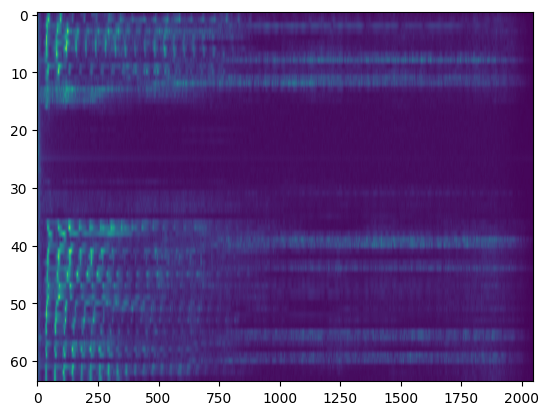

In [51]:
show_img(spec.squeeze())

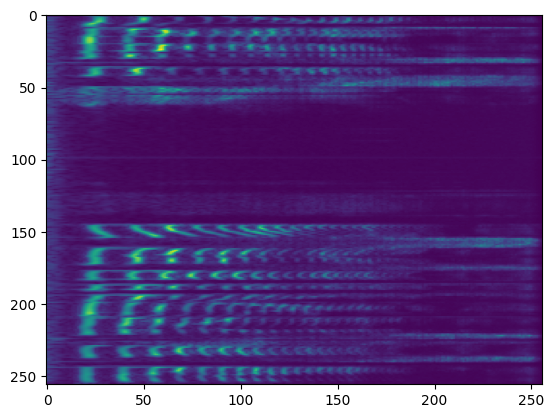

In [52]:
show_img(mel_spec.squeeze())